In [ ]:
! pip install scikit-learn

In [13]:
! pip install keras

     |████████████████████████████████| 378kB 155kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/10/56/d5c53cd170529bb40cd7dd43e2b68944cb65a45f65ab4c78a68f4ac9e51e/h5py-2.10.0-cp35-cp35m-manylinux1_x86_64.whl


In [89]:
! pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 21kB/s  eta 0:00:01    |█▏                              | 15.6MB 1.0MB/s eta 0:06:25     |███▌                            | 45.5MB 731kB/s eta 0:08:22     |████▌                           | 58.2MB 989kB/s eta 0:05:59     |█████                           | 63.7MB 753kB/s eta 0:07:43     |███████▉                        | 101.3MB 960kB/s eta 0:05:24     |███████▉                        | 101.6MB 960kB/s eta 0:05:24     |████████▉                       | 113.1MB 1.6MB/s eta 0:03:09     |█████████▌                      | 122.0MB 1.4MB/s eta 0:03:25     |████████████▋                   | 162.8MB 1.6MB/s eta 0:02:35
  Using cached https://files.pythonhosted.org/packages/de/62/2ee9cd74c9fa2fa450877847ba560b260f5d0fb70ee0595203082dafcc9d/tensorflow_estimator-1.15.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1e/e9/d3d747a97f7188f48aa5eda486907f3b345cd409f0a0850468ba867db246/tensorboard-1.15.0-py3-none-any.whl
  Fou

In [201]:
! pip install tqdm

     |████████████████████████████████| 61kB 31kB/s eta 0:00:01


In [1]:
import pandas as pd

In [2]:
import mne

KeyboardInterrupt: 

In [ ]:
import numpy as np

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dropout, Dense, Conv2D, MaxPool2D

In [ ]:
from keras.utils import to_categorical

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

In [ ]:
import tensorflow as tf

In [ ]:
import keras.backend as K

In [ ]:
SAMPLE_RATE = 160
WINDOW_DURATION = 2
CHANNELS = 3
ALL_FREQUENCIES = np.arange(7, 45, 1)
FREQUENCIES = ALL_FREQUENCIES.shape[0]

- Input - 2s spectre
- Output - left, right, none

# Dataset extraction

Подготовка датасета:
- Для каждого файла, соответствующего таске 1:
    - Считываем
    - Получаем tfr для каждого события
    - Нормируем tfr к первым секундам
    - Выбираем каналы
    - Сохраняем в X дату
- Меняем формат на channels_first
- При разделении датасета:
    - Используем ридер, для которого указываем субъектов для считывания
    - Делаем рандомный селект субъектов

Не забыть активировать видеокарту!

In [12]:
def read_epochs(path, tmin=-1, tmax=4):
    eeg = mne.io.read_raw_edf(
        path, 
        preload=True,
        exclude=["T9..", "T10."]
    )
    eeg.rename_channels(lambda x: x.strip('.'))
    eeg.filter(2, 50)
    events, annot_to_events = mne.events_from_annotations(eeg)
    picks = mne.pick_channels(eeg.info["ch_names"], ["C3", "Cz", "C4"])
    epochs = mne.Epochs(
        eeg, 
        events, 
        event_id={
            "none": 1,
            "left": 2,
            "right": 3
        },
        tmin=tmin - 0.5,
        tmax=tmax + 0.5,
        picks=picks,
        preload=True,
    )
    return epochs

In [13]:
epochs = read_epochs("./S001R03.edf")

Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 

In [14]:
def get_power(epochs, event, baseline, tmin=-1, tmax=4, frequencies=ALL_FREQUENCIES):
    power = mne.time_frequency.tfr_multitaper(
        epochs[event], 
        freqs=frequencies, 
        n_cycles=frequencies,
        return_itc=False, 
        decim=3, 
        n_jobs=1,
        average=False
    )
    power.apply_baseline(baseline, mode='percent')
    power.crop(0, tmax) # TODO check tmin, this is for cropping baseline
    return power.data

In [15]:
power = get_power(epochs, "left", [-1, 0])

Not setting metadata
Applying baseline correction (mode: percent)


In [19]:
def read_data(subjects):
    X = []
    y = []
    for subject in tqdm_notebook(subjects):
        path = "./full-data/eegmmidb-1.0.0.physionet.org/S{:03d}/".format(subject)
        for task in [4, 8, 12]:#[3, 7, 11]:
            file = "S{:03d}R{:02d}.edf".format(subject, task)
            full_path = path + file
            print("Reading:", full_path)
            try:
                epochs = read_epochs(full_path)
            except:
                print("File not exists")
                continue
            for event_index, event in enumerate(["left", "right"]):
                if event == "none":
                    baseline = [2, 3]
                else:
                    baseline = [-1, 0]
                power = get_power(epochs, event, baseline)
                X.append(power)
                y.append([event_index] * power.shape[0])
    return X, y

In [20]:
X, y = read_data([1])

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S001/S001R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baselin

In [21]:
train_rate = 0.8
all_subjects = np.arange(1, 109)
train_subjects = np.random.choice(all_subjects, int(train_rate * len(all_subjects)))
test_subjects = [s for s in all_subjects if s not in train_subjects]

In [22]:
train_X, train_y = read_data(train_subjects)

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S066/S066R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baselin

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S021/S021R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S

30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S080/S080R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S080/S080R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S061/S061R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S061/S061R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S060/S060R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S008/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S083/S083R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S083/S083R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S081/S081R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S081/S081R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S092/S092R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S092/S092R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S064/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S068/S068R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S057/S057R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S057/S057R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S042/S042R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S042/S042R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S024/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S086/S086R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S086/S086R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S031/S031R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S031/S031R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S069/S069R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S040/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S005/S005R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S011/S011R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S011/S011R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S071/S071R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S071/S071R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S096/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S010/S010R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S010/S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S097/S097R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S097/S097R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S045/S045R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S045/S045R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S048/S0

- Filter length: 211 samples (1.648 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
38 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 38 events and 769 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S088/S088R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S088/S088R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S078/S078R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S078/S078R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S069/S069R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S061/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S093/S093R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S039/S039R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S039/S039R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S030/S030R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S030/S030R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

In [23]:
test_X, test_y = read_data(test_subjects)

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S002/S002R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baselin

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S006/S006R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S

30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S009/S009R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S018/S018R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S018/S018R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S026/S026R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S026/S026R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S029/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S033/S033R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S033/S033R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S037/S037R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S037/S037R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S056/S056R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S056/S056R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S062/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S070/S070R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S070/S070R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S079/S079R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S079/S079R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up 

Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S084/S084R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S084/S084R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S090/S0

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S095/S095R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S095/S095R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

<ipython-input-12-32745a652d46>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S100/S100R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S100/S100R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

<ipython-input-12-32745a652d46>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S100/S100R12.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S100/S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

<ipython-input-12-32745a652d46>:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  exclude=["T9..", "T10."]


Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S101/S101R04.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S104/S1

- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
1 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Not setting metadata
Applying baseline correction (mode: percent)
Reading: ./full-data/eegmmidb-1.0.0.physionet.org/S106/S106R08.edf
Extracting EDF parameters from /home/noomkcalb/Документы/neuroscience/right-left/full-data/eegmmidb-1.0.0.physionet.org/S106/S106R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T2', 'T0', 'T1']
30 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 30 events and 961 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction 

In [31]:
# def process_signals(X, min_size=None):
#     if not min_size:
#         min_size = min([x.shape[-1] for x in X])
#     stacked_X = np.vstack([x[..., :min_size] for x in X])
#     return np.swapaxes(stacked_X, 1, -1)

In [32]:
def process_signals(X, y, preferred_size=None):
    if not preferred_size:
        preferred_size = max([x.shape[-1] for x in X])
    selected_y = [y[i] for i, x in enumerate(X) if x.shape[-1] >= preferred_size]
    flattened_y = [e for y_list in y for e in y_list]
    stacked_X = np.vstack([x[..., :preferred_size] for x in X if x.shape[-1] >= preferred_size])
    prepared_y = to_categorical(flattened_y).T[0]
    return np.swapaxes(stacked_X, 1, -1), prepared_y

In [45]:
selected_y = [y[i] for i, x in enumerate(X) if x.shape[-1] >= preferred_size]

In [47]:
flattened_y = [e for y_list in y for e in y_list]

In [56]:
len(flattened_y)

45

In [50]:
stacked_X = np.vstack([x[..., :preferred_size] for x in X if x.shape[-1] >= preferred_size])

In [57]:
stacked_X.shape

(45, 3, 38, 214)

In [33]:
prepared_train_X, prepared_train_y = process_signals(train_X, train_y)

In [37]:
SAMPLES = prepared_train_X.shape[1]

In [77]:
len(train_X)

516

In [39]:
prepared_train_X.shape

(3510, 214, 38, 3)

In [42]:
prepared_train_y.shape

(3726,)

In [40]:
prepared_test_X, prepared_test_y = process_signals(test_X, test_y, preferred_size=SAMPLES)

In [44]:
prepared_test_X.shape

(1927, 214, 38, 3)

In [43]:
prepared_test_y.shape

(1963,)

In [45]:
for i in range(0, 3):
    plt.imshow(prepared_train_X[prepared_train_y == 1][i, ..., 0].T)
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3555 but corresponding boolean dimension is 498

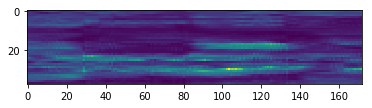

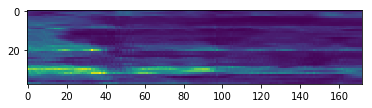

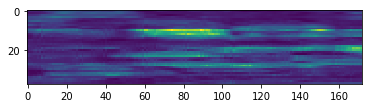

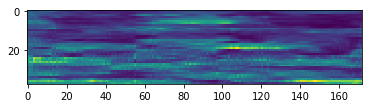

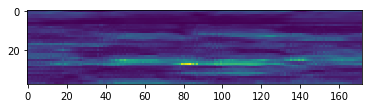

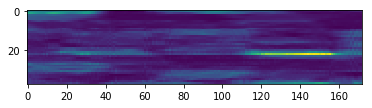

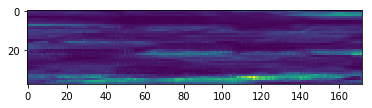

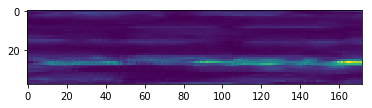

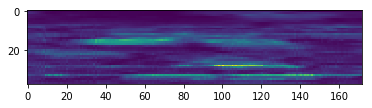

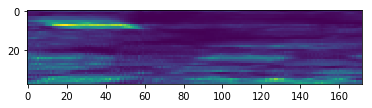

In [42]:
for i in range(0, 10):
    plt.imshow(prepared_train_X[train_y == 0][i, ..., 0].T)
    plt.show()

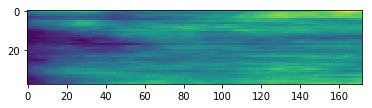

In [32]:
plt.imshow(prepared_train_X[train_y == 1][..., 0].mean(axis=0).T)

# Model code

- Input channels x frequencies x time
- Conv Fx3, 8
- Maxpool
- Conv Fx3, 64
- Maxpool
- Flatten
- Dropout, 0.2
- Full, 100
- Dropout, 0.2
- Softmax, 3

In [33]:
# SAMPLES = SAMPLE_RATE * WINDOW_DURATION

In [34]:
CONVOLUTIONS = [8, 64, 128]
DROPOUT_RATE = 0.5
FULLY_CONNECTED = 1024
BATCH_SIZE = 64

In [35]:
model = Sequential()

model.add(Conv2D(
    CONVOLUTIONS[0], (3, 3), 
    input_shape=(SAMPLES, FREQUENCIES, CHANNELS),
    padding='same'
))

for prev, filters in enumerate(CONVOLUTIONS[1:]):
    model.add(Conv2D(filters, (3, 3), padding='same', activation="relu"))
    model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(FULLY_CONNECTED, activation="relu"))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(3, activation="softmax"))

In [36]:
# model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [37]:
model.layers[4].output.shape

TensorShape([Dimension(None), Dimension(43), Dimension(9), Dimension(128)])

In [38]:
# mock_X = np.random.randn(BATCH_SIZE * 10, FREQUENCIES, SAMPLES, CHANNELS)
# mock_y = np.eye(3)[np.random.choice(3, BATCH_SIZE * 10)]

In [39]:
model.fit(
    prepared_train_X, train_y, 
    validation_data=(prepared_test_X, test_y),
    epochs=10, batch_size=BATCH_SIZE
)


Train on 3711 samples, validate on 2184 samples
Epoch 1/10
3711/3711 [==============================] - 59s 16ms/step - loss: 1.3038 - accuracy: 0.5120 - val_loss: 0.6932 - val_accuracy: 0.5023
Epoch 2/10
1792/3711 [=============>................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5095

KeyboardInterrupt: 

array([False, False, False, ...,  True,  True,  True])

# Interpretation

In [36]:
predictions = model.predict(prepared_train_X)
train_y_pred = to_categorical(np.argmax(predictions, axis=1).tolist())

In [37]:
print(multilabel_confusion_matrix(
    train_y, 
    train_y_pred
))

[[[3227    0]
  [   0 3175]]

 [[3973  808]
  [ 306 1315]]

 [[4490  306]
  [ 808  798]]]


In [164]:
maximized_input = 0.001 * np.random.randn(1, SAMPLES, FREQUENCIES, CHANNELS)

In [165]:
target = [[0, 0, 1]]

loss = K.categorical_crossentropy(target, model.output)
grads = K.gradients(loss, model.input)

In [166]:
s = K.get_session()

In [167]:
epsilon = 0.01

https://github.com/soumyac1999/FGSM-Keras/blob/master/targeted_attack.ipynb

In [168]:
for i in tqdm_notebook(range(0, 100)):
    grad_values,  = s.run(grads, {
        model.input: maximized_input
    })
    maximized_input -= epsilon * grad_values

/home/noomkcalb/.virtualenvs/neuro/lib/python3.5/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


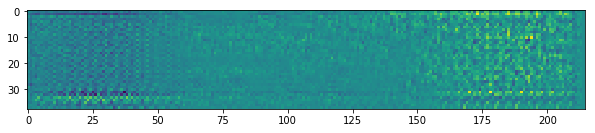

In [169]:
plt.figure(figsize=(10, 3))
plt.imshow(maximized_input[0, ..., 0].T)